<a href="https://colab.research.google.com/github/junhyeokk/boomhill24/blob/main/model/baseline-model-train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import os
import csv
import random
import numpy as np
from PIL import Image as PIL_Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

from torchvision import transforms
from torchvision.models import resnet50, resnet34

In [3]:
seed = 365

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)    
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
drivepath = "/content/gdrive/MyDrive/simple_data"

In [5]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
# device_type = "cpu"
device = torch.device(device_type)
print(device)

cuda


In [6]:
class KartModel1(nn.Module):
  def __init__(self, class_num = 8):
    super(KartModel1, self).__init__()
    self.class_num = class_num
    self.backbone = resnet34(pretrained=True)
    self.backbone.fc = nn.Sequential(
      nn.Linear(in_features=512, out_features=256, bias=True),
      nn.BatchNorm1d(256),
      nn.ReLU(),
      nn.Linear(in_features=256, out_features=class_num, bias=True),
      # nn.Softmax(dim=1)
      # nn.Sigmoid(),
    )
  
  def forward(self, input_image):
    output = self.backbone(input_image)

    return output

In [7]:
class KartDataSet1(data.Dataset):
  def __init__(self, csv_files):
    self.images = []
    self.labels = []

    for csv_file in csv_files:
      with open(csv_file) as csvfile:
        csv_reader = csv.reader(csvfile)
        # next(csv_reader, None)        # 첫번째 row 스킵
        
        for row in csv_reader:
          self.images.append(drivepath + '/csvs/' + row[0])
          # self.labels.append([int(x) for x in list(row[1][:3])])
          self.labels.append(int(row[1][:3], 2))

  def __getitem__(self, index):
    image_path = self.images[index]
    image = PIL_Image.open(image_path)

    label = self.labels[index]

    preprocess = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),     # -1 ~ 1 로 normalize
    ])
    
    return preprocess(image), label

  def __len__(self):
    return len(self.images)

In [8]:
train_dataset = KartDataSet1([f"{drivepath}/csvs/data_test_{i}.csv" for i in [1, 2, 3, 4, 5, 6, 8, 9]])
validation_dataset = KartDataSet1([f"{drivepath}/csvs/data_test_0.csv"])
print(train_dataset[0][0])
print(train_dataset[0][1])

tensor([[[-0.0196, -0.0118,  0.0039,  ..., -0.4353, -0.4588, -0.4745],
         [-0.2784, -0.2549, -0.2314,  ..., -0.5059, -0.5294, -0.5451],
         [-0.3255, -0.3255, -0.3176,  ..., -0.5294, -0.5529, -0.5686],
         ...,
         [-0.8588, -0.8588, -0.8588,  ..., -0.0118, -0.0118, -0.0118],
         [-0.7961, -0.7961, -0.7961,  ...,  0.0196,  0.0118,  0.0118],
         [-0.6941, -0.6941, -0.6941,  ...,  0.1922,  0.1843,  0.1843]],

        [[ 0.2706,  0.2784,  0.3020,  ..., -0.0588, -0.0824, -0.0980],
         [ 0.0275,  0.0353,  0.0588,  ..., -0.1294, -0.1529, -0.1686],
         [-0.0196, -0.0196, -0.0118,  ..., -0.1529, -0.1765, -0.1922],
         ...,
         [-0.5059, -0.5059, -0.5059,  ...,  0.0118,  0.0118,  0.0118],
         [-0.4431, -0.4431, -0.4431,  ...,  0.0431,  0.0353,  0.0353],
         [-0.3412, -0.3412, -0.3412,  ...,  0.2157,  0.2078,  0.2078]],

        [[ 0.3961,  0.4039,  0.4039,  ...,  0.0980,  0.0745,  0.0588],
         [ 0.1608,  0.1608,  0.1765,  ...,  0

# 하이퍼 파라미터 설정

In [9]:
num_epochs = 10
lr = 1e-4
batch_size = 16
log_interval = 10

In [10]:
train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
)

validation_loader = data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
)

print(len(train_dataset))
print(len(validation_dataset))
print(len(train_loader))
print(len(validation_loader))

8021
1296
502
81


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
save_path = drivepath + "/test_model.pt"

model = KartModel1()
# model.load_state_dict(torch.load(save_path))

for param, weight in model.named_parameters():
    print(f"param {param:20} required gradient? -> {weight.requires_grad}")
model = model.to(device)

param backbone.conv1.weight required gradient? -> True
param backbone.bn1.weight  required gradient? -> True
param backbone.bn1.bias    required gradient? -> True
param backbone.layer1.0.conv1.weight required gradient? -> True
param backbone.layer1.0.bn1.weight required gradient? -> True
param backbone.layer1.0.bn1.bias required gradient? -> True
param backbone.layer1.0.conv2.weight required gradient? -> True
param backbone.layer1.0.bn2.weight required gradient? -> True
param backbone.layer1.0.bn2.bias required gradient? -> True
param backbone.layer1.1.conv1.weight required gradient? -> True
param backbone.layer1.1.bn1.weight required gradient? -> True
param backbone.layer1.1.bn1.bias required gradient? -> True
param backbone.layer1.1.conv2.weight required gradient? -> True
param backbone.layer1.1.bn2.weight required gradient? -> True
param backbone.layer1.1.bn2.bias required gradient? -> True
param backbone.layer1.2.conv1.weight required gradient? -> True
param backbone.layer1.2.bn1.w

In [12]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
# scheduler = StepLR(optimizer, 5, gamma=0.5)
scheduler = CosineAnnealingLR(optimizer, T_max=50)

In [13]:
it = iter(train_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


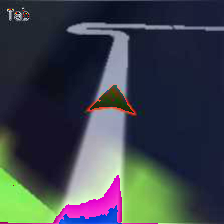

tensor([7, 7, 6, 7, 2, 0, 7, 0, 0, 3, 0, 0, 5, 7, 0, 0], device='cuda:0')
tensor([4, 4, 1, 5, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 6, 5], device='cuda:0')
tensor(0, device='cuda:0')
tensor([4, 4, 1, 5, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 6, 5])
tensor(2.3877, grad_fn=<CopyBackwards>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [14]:
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

inputs, labels = next(it)
display(to_img(inputs[0]))

inputs = inputs.to(device)
labels = labels.to(device)
outs = model(inputs)
preds = torch.argmax(outs, dim=-1)
print(preds)
print(labels)
print((preds == labels).sum())
loss = criterion(outs, labels)
print(labels.cpu())
print(loss.cpu())

In [15]:
!pip install wandb

In [16]:
import wandb

wandb.login()

wandb: Currently logged in as: junhyeokk (use `wandb login --relogin` to force relogin)


True

In [17]:
config = {}
config['n_epochs'] = num_epochs
config['batch_size'] = batch_size
config['lr'] = lr


wandb.init(project="boomhill24_12", config=config)

In [18]:
for epoch in range(num_epochs):
  model.eval()
  validation_matches = 0
  validation_loss_value = 0
  for idx, validation_batch in enumerate(validation_loader):
    inputs, labels = validation_batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    outs = model(inputs)
    preds = torch.argmax(outs, dim=-1)
    loss = criterion(outs, labels)

    validation_loss_value += loss.item()
    validation_matches += (preds == labels).sum().item()

  validation_loss = validation_loss_value / batch_size / len(validation_loader)
  validation_acc = validation_matches / batch_size / len(validation_loader)
  wandb.log({"validation_loss" : validation_loss, "validation_acc" : validation_acc})
  print(
      f"Validation[{epoch + 1}/{num_epochs}] || ",
      f"validation loss {validation_loss:4.4} || validation accuracy {validation_acc:4.2%}"
  )

  model.train()
  loss_value = 0
  matches = 0
  
  for idx, train_batch in enumerate(train_loader):
    inputs, labels = train_batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    outs = model(inputs)
    # preds = (outs > 0.5)
    preds = torch.argmax(outs, dim=-1)
    loss = criterion(outs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_value += loss.item()
    matches += (preds == labels).sum().item()
    # matches = ((preds == labels).sum(axis = 1) == 6).sum()

    # wandb.log({"epoch" : epoch, "training_loss" : loss.item(), "training_acc" : matches / batch_size})
    if (idx + 1) % log_interval == 0:
      train_loss = loss_value / batch_size / log_interval
      train_acc = matches / batch_size / log_interval
      current_lr = scheduler.get_last_lr()
      
      wandb.log({"epoch" : epoch, "training_loss" : train_loss, "training_acc" : train_acc, "lr" : current_lr})
      print(
          f"Epoch[{epoch + 1}/{num_epochs}]({idx + 1}/{len(train_loader)}) || ",
          f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
      )

      loss_value = 0
      matches = 0

    scheduler.step()

model.eval()
validation_matches = 0
validation_loss_value = 0
for idx, validation_batch in enumerate(validation_loader):
  inputs, labels = validation_batch
  inputs = inputs.to(device)
  labels = labels.to(device)

  outs = model(inputs)
  preds = torch.argmax(outs, dim=-1)
  loss = criterion(outs, labels)

  validation_loss_value += loss.item()
  validation_matches += (preds == labels).sum().item()

validation_loss = validation_loss_value / batch_size / len(validation_loader)
validation_acc = validation_matches / batch_size / len(validation_loader)
wandb.log({"validation_loss" : validation_loss, "validation_acc" : validation_acc})
print(
    f"Validation[{epoch + 1}/{num_epochs}] || ",
    f"validation loss {validation_loss:4.4} || validation accuracy {validation_acc:4.2%}"
)

torch.save(model.state_dict(), save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validation[1/10] ||  validation loss 0.1276 || validation accuracy 11.34%
Epoch[1/10](10/502) ||  training loss 0.1404 || training accuracy 10.62% || lr [9.221639627510075e-05]
Epoch[1/10](20/502) ||  training loss 0.1262 || training accuracy 35.62% || lr [6.840622763423389e-05]
Epoch[1/10](30/502) ||  training loss 0.1196 || training accuracy 42.50% || lr [3.756550564175724e-05]
Epoch[1/10](40/502) ||  training loss 0.1129 || training accuracy 51.25% || lr [1.1474337861210536e-05]
Epoch[1/10](50/502) ||  training loss 0.1151 || training accuracy 46.25% || lr [9.866357858642197e-08]
Epoch[1/10](60/502) ||  training loss 0.1204 || training accuracy 49.38% || lr [7.78360372489924e-06]
Epoch[1/10](70/502) ||  training loss 0.1015 || training accuracy 65.62% || lr [3.15937723657661e-05]
Epoch[1/10](80/502) ||  training loss 0.1091 || training accuracy 58.13% || lr [6.243449435824273e-05]
Epoch[1/10](90/502) ||  training loss 0.09364 || training accuracy 63.75% || lr [8.852566213878945e-05]